In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
# load the data
data = pd.read_csv('btc_ta.csv')

In [3]:
# examine the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638440 entries, 0 to 2638439
Data columns (total 74 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   time                       int64  
 2   open                       float64
 3   close                      float64
 4   high                       float64
 5   low                        float64
 6   volume                     float64
 7   volume_adi                 float64
 8   volume_obv                 float64
 9   volume_cmf                 float64
 10  volume_fi                  float64
 11  volume_em                  float64
 12  volume_sma_em              float64
 13  volume_vpt                 float64
 14  volume_nvi                 float64
 15  volatility_atr             float64
 16  volatility_bbm             float64
 17  volatility_bbh             float64
 18  volatility_bbl             float64
 19  volatility_bbw             float64
 20  vo

In [4]:
# create the target feature
data['nextClosingPrice'] = data['close'].shift(1)

# drop the rows with 'None' in target column
data = data.dropna(subset=['nextClosingPrice'])

In [5]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [6]:
def testModel(df, windowLength, upToSize, stepSize):

    # lists to store data, will concat to make result data frame
    rmseList = []
    predList = []
    realList = []
    predTimeList = []
    
    # extract feature and test data
    X = df.drop(['Unnamed: 0', 'time', 'nextClosingPrice'], axis=1)
    y = df['nextClosingPrice']

    # rolling window test
    for i in range(windowLength, upToSize, stepSize):
        
        # split the data
        X_train, X_test = X[i-windowLength:i], X[i:i+1]
        y_train, y_test = y[i-windowLength:i], y[i:i+1]
        
        # createa new model and fit it
        model = XGBRegressor()
        model.fit(X_train, y_train)

        # make a prediction
        y_pred = model.predict(X_test)
        
        # record time figures for result data frame
        predTimeList.append(df['time'][i])
        predList.append(y_pred)
        realList.append(y_test)
        
        # measure the error of this prediction
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmseList.append(rmse)
        
    # result dictionary
    result_data = pd.DataFrame({'Timestamp': predTimeList, "Real": realList, "Preds": predList, 'rmse': rmseList})
    
    # result plot
    plt.plot('Timestamp', 'Real', data=result_data)
    plt.plot('Timestamp', 'Preds', data=result_data)
    plt.legend()
    
    print("")
    print("RMSE mean:{}, std:{}".format(result_data['rmse'].mean(), result_data['rmse'].std()))
    
    return result_data


RMSE mean:0.22419792930917937, std:0.25265014189752655


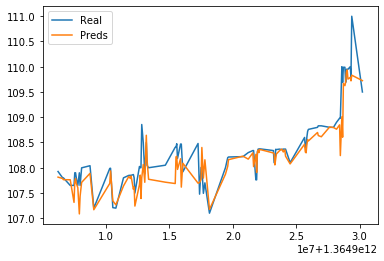

In [7]:
# test an xgb model trained over the previous 360 days
xgb_results = testModel(data, 360, 460, 1)